<a href="https://colab.research.google.com/github/joeldmott/inventory_project/blob/main/inventory_restocking_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing packages to read in data from Kaggle host site
import json
import os
from pathlib import Path
from google.colab import userdata

# api key for importing Kaggle and downloading the datasets
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

# api key for the json object below
api_key = userdata.get('API_KEY')

# using pathlib Path
kaggle_path = Path('/root/.kaggle')
os.makedirs(kaggle_path, exist_ok=True)

# opening file and dumps python dict to json object
with open (kaggle_path/'kaggle.json', 'w') as handl:
    json.dump(api_key,handl)

os.chmod(kaggle_path/'kaggle.json', 600)

In [2]:
import kaggle
! kaggle datasets download joelmott/liquor-inventory-dataset

Dataset URL: https://www.kaggle.com/datasets/joelmott/liquor-inventory-dataset
License(s): MIT
 85% 57.0M/67.1M [00:01<00:00, 62.7MB/s]
100% 67.1M/67.1M [00:01<00:00, 66.8MB/s]


In [3]:
!unzip liquor-inventory-dataset.zip

Archive:  liquor-inventory-dataset.zip
  inflating: liquor sales dataset.csv  


In [4]:
import pandas as pd
df = pd.read_csv('/content/liquor sales dataset.csv')
df.head()

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,...,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,S24127700024,2/19/2015,3678,"Smoke Shop, The",1918 SE 14TH ST,DES MOINES,50320,POINT (-93.597011 41.570844),77.0,Polk,...,41783,Uv Blue Raspberry Vodka Mini,6,500,4.89,7.34,2,14.68,1.0,0.26
1,S15066200002,10/10/2013,2633,Hy-Vee #3 / BDI / Des Moines,3221 SE 14TH ST,DES MOINES,50320,POINT (-93.596754 41.554101),77.0,Polk,...,904969,Sabe Premiom Sake Double Barrel,6,750,14.99,22.49,6,134.94,4.5,1.19
2,S19323500030,6/3/2014,2607,Hy-Vee Wine and Spirits / Shenandoah,520 SO FREMONT,SHENANDOAH,51601,POINT (-95.385111 40.761736),73.0,Page,...,45277,Paramount White Rum,12,1000,4.34,6.51,12,78.12,12.0,3.17
3,S23334500013,1/6/2015,4810,Kum & Go #518 / Ankeny,3603 NE OTTERVIEW CIRCLE,ANKENY,50021,POINT (-93.572458 41.760989),77.0,Polk,...,43121,Bacardi Superior Rum Mini,12,500,5.54,8.31,1,8.31,0.5,0.13
4,S09742200010,12/27/2012,4025,Karam Kaur Khasriya Llc,702 13TH ST,BELLE PLAINE,52208,POINT (-92.277759 41.897052),6.0,Benton,...,11298,Crown Royal Canadian Whisky,6,1750,31.00,46.49,2,92.98,3.5,0.92


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Invoice/Item Number    1048575 non-null  object 
 1   Date                   1048575 non-null  object 
 2   Store Number           1048575 non-null  int64  
 3   Store Name             1048575 non-null  object 
 4   Address                1047448 non-null  object 
 5   City                   1047448 non-null  object 
 6   Zip Code               1047439 non-null  object 
 7   Store Location         954963 non-null   object 
 8   County Number          1045978 non-null  float64
 9   County                 1045978 non-null  object 
 10  Category               1048341 non-null  float64
 11  Category Name          1048053 non-null  object 
 12  Vendor Number          1048575 non-null  int64  
 13  Vendor Name            1048575 non-null  object 
 14  Item Number       

In [6]:
#Where are these stores?
#df.sample(50)
#Ah, they're all in (and from all around) Iowa.

In [7]:
#What's the date range?
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].min(), df['Date'].max()

(Timestamp('2012-01-03 00:00:00'), Timestamp('2018-10-08 00:00:00'))

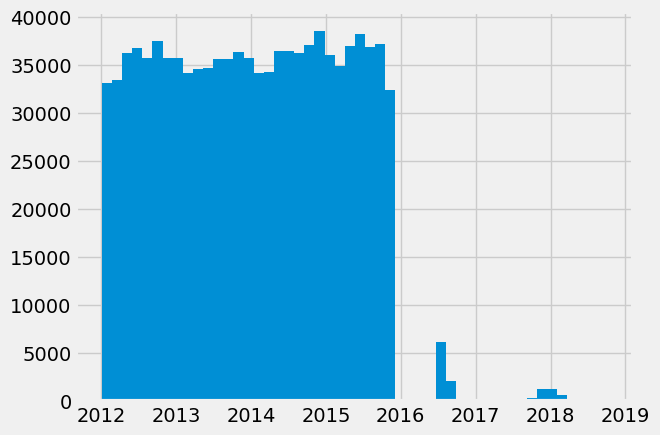

In [88]:
df['Date'].hist(bins=50);

In [80]:
df['Date']

0         2015-02-19
1         2013-10-10
2         2014-06-03
3         2015-01-06
4         2012-12-27
             ...    
1048570   2014-01-13
1048571   2013-09-09
1048572   2015-04-07
1048573   2012-11-29
1048574   2012-08-13
Name: Date, Length: 1048575, dtype: datetime64[ns]

Obviously, we'll drop the random few date entries from 2016-2018, but the real tragedy here is the missing data from the very end of 2015. I don't think it's a good idea to try and impute and time-series data here, so we'll have to drop everything from 2015 on. However, this still gives us three complete years of data, which isn't bad.

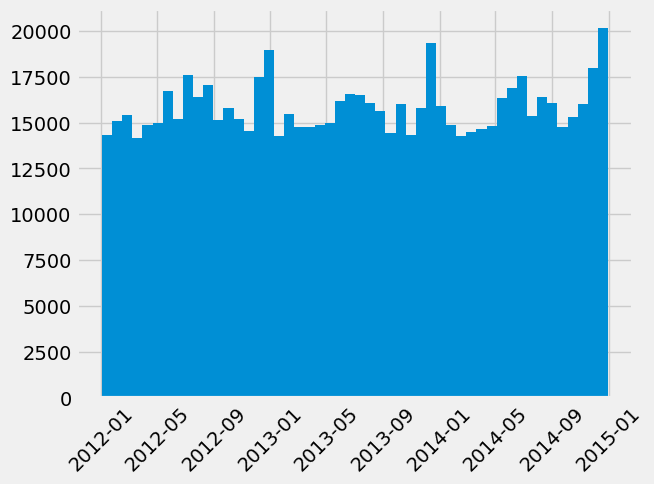

In [87]:
trimmed_df = df[~(df['Date']>'2015-01-03 00:00:00')]
trimmed_df['Date'].hist(xrot=45, bins=50);

In [8]:
#How many stores?
unique_stores = df['Store Number'].unique()
len(unique_stores)

1710

In [9]:
#How many with more than 100 orders in here?
store_value_counts = df['Store Number'].value_counts()
hundred_order_stores = pd.DataFrame(store_value_counts)
hundred_order_stores = hundred_order_stores[hundred_order_stores['count']>= 100]
len(hundred_order_stores)

1213

In [10]:
#How many with more than 1000 orders in here?
store_value_counts = df['Store Number'].value_counts()
thousand_order_stores = pd.DataFrame(store_value_counts)
thousand_order_stores = thousand_order_stores[thousand_order_stores['count']>= 1000]
len(thousand_order_stores)

290

That's a good amount of stores with a decent amount of rows to examine. We may wind up looking at the top ten or top 100 stores only depending on how the project goes, but maybe we can incorporate all 290.

Let's also look at vendors; while stores represent a variable that we may use to *subdivide* the dataset, vendors will remain an independent variable. As a categorical variable, they may balloon out to an overwhelming number of one-hot encoded variables, so we'll alomost certainly need to find a way to limit these.

In [11]:
#How many vendors total?
len(df['Vendor Name'].unique())

224

In [12]:
#How many with more than 100 orders in here?
vendor_value_counts = df['Vendor Name'].value_counts()
hundred_order_vendors = pd.DataFrame(vendor_value_counts)
hundred_order_vendors = hundred_order_vendors[hundred_order_vendors['count'] >= 100]
len(hundred_order_vendors)

77

In [13]:
#How many with more than 1000 orders in here?
thousand_order_vendors = pd.DataFrame(vendor_value_counts)
thousand_order_vendors = thousand_order_vendors[thousand_order_vendors['count'] >= 1000]
len(thousand_order_vendors)

35

35 vendors combined with the liqour categories and a few more continuous columns is probably still going to be too many to model without a problematic amount of noise and/or sparsity in our data. We may consider adding a limitation here to each store along the way. In other words, when we run a model on an individual store, we'll only include vendors that serviced that store with >= 1,000 orders.

This is especially important when we consider that this dataset covers an entire *state* with urban, suburban, and rural stores that all move different volumes of inventory; the vendors used will almost certainly vary from one store to the next.

Before we start examining stores in more detail, we need to take care of a few other things in our broader DataFrame. Specifically, we need to drop unnecessary columns and contend with what appear to be a few NaNs.

Let's first examine columns so we can see which to drop. I appreciate how the data has store, location, and item names and numbers, but for our purposes, we can drop a number of these redundancies.

In [46]:
columns_to_drop = ['Invoice/Item Number', 'Store Name', 'Address', 'City', 'Zip Code',
                   'Store Location', 'County Number', 'County', 'Category', 'Vendor Number',
                   'Item Number', 'Item Description', 'Bottle Volume (ml)', 'State Bottle Cost',
                   'State Bottle Retail', 'Volume Sold (Liters)', 'Volume Sold (Gallons)']
trimmed_df = df.drop(columns_to_drop, axis=1)
trimmed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   Date            1048575 non-null  datetime64[ns]
 1   Store Number    1048575 non-null  int64         
 2   Category Name   1048053 non-null  object        
 3   Vendor Name     1048575 non-null  object        
 4   Pack            1048575 non-null  int64         
 5   Bottles Sold    1048575 non-null  int64         
 6   Sale (Dollars)  1048571 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 56.0+ MB


This may seem like just a few columns for now, but once we add the categorical columns in, this will quickly expand. Let's handle the NaN's now.

In [47]:
nan_rows = trimmed_df[trimmed_df.isna().any(axis=1)]
len(nan_rows)

526

In [48]:
len(nan_rows) / len(trimmed_df)

0.0005016331688243569

NaN's only make up 0.05% of our data, so we can afford to drop them without sarcificing much data.

In [49]:
trimmed_df.dropna(axis=0, inplace=True)
trimmed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1048049 entries, 0 to 1048574
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   Date            1048049 non-null  datetime64[ns]
 1   Store Number    1048049 non-null  int64         
 2   Category Name   1048049 non-null  object        
 3   Vendor Name     1048049 non-null  object        
 4   Pack            1048049 non-null  int64         
 5   Bottles Sold    1048049 non-null  int64         
 6   Sale (Dollars)  1048049 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 64.0+ MB


Now we can examine the categorical columns more carefully. We'll use the 'Store Number' column later on in order to subdivide the trimmed_df into stores, so let's begin with the 'Category Name' column.

In [50]:
len(trimmed_df['Category Name'].value_counts())

126

In [51]:
print(trimmed_df['Category Name'].value_counts().to_string())

Category Name
VODKA 80 PROOF                          130685
CANADIAN WHISKIES                        97766
STRAIGHT BOURBON WHISKIES                57021
SPICED RUM                               55598
VODKA FLAVORED                           52326
BLENDED WHISKIES                         47028
TEQUILA                                  45050
IMPORTED VODKA                           43040
PUERTO RICO & VIRGIN ISLANDS RUM         42680
WHISKEY LIQUEUR                          33616
AMERICAN COCKTAILS                       30734
FLAVORED RUM                             29375
AMERICAN DRY GINS                        27623
IMPORTED VODKA - MISC                    27397
MISC. IMPORTED CORDIALS & LIQUEURS       26579
AMERICAN GRAPE BRANDIES                  26035
TENNESSEE WHISKIES                       25727
CREAM LIQUEURS                           24791
SCOTCH WHISKIES                          21475
IMPORTED SCHNAPPS                        18274
IMPORTED GRAPE BRANDIES                  15988

That's too many to include all of them. Instead, we'll carefully consolidate these into more generalized categories. On one hand, we need to narrow these down for clarity and modeling purposes. On the other hand, we don't want to eliminate too many categories, especially those with a larger value count.

For example, instead of just consolidating everything containing the string 'VODKA' to a general 'VODKA' category, we can at least distinguish between 'VODKA' and a new category called 'FLAVORED VODKA'. We can also do something like divide the whiskey categories into three new ones: 'BOURBON', 'SCOTCH', and 'OTHER WHISKEY'.

In [52]:
#I can use the str.contains method for some categories that are easier
# to generalize. Let's do those first:
trimmed_df.loc[trimmed_df['Category Name'].str.contains('BOURBON'), 'Category Name'] = 'BOURBON'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('Bourbon'), 'Category Name'] = 'BOURBON'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('RYE'), 'Category Name'] = 'BLENDED AND OTHER WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('Rye'), 'Category Name'] = 'BLENDED AND OTHER WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('Tequila'), 'Category Name'] = 'TEQUILA'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('VODKA'), 'Category Name'] = 'VODKA'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('Vodka'), 'Category Name'] = 'VODKA'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('VODKAS'), 'Category Name'] = 'VODKA'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('Vodkas'), 'Category Name'] = 'VODKA'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('GIN'), 'Category Name'] = 'GIN'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('Gin'), 'Category Name'] = 'GIN'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('RUM'), 'Category Name'] = 'RUM'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('Rum'), 'Category Name'] = 'RUM'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('AMARETTO'), 'Category Name'] = 'LIQUEUR'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('Amaretto'), 'Category Name'] = 'LIQUEUR'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('LIQUEUR'), 'Category Name'] = 'LIQUEUR'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('Liqueur'), 'Category Name'] = 'LIQUEUR'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('CREME DE'), 'Category Name'] = 'LIQUEUR'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('COCKTAILS'), 'Category Name'] = 'RTD COCKTAILS'
trimmed_df.loc[trimmed_df['Category Name'].str.contains('Cocktails'), 'Category Name'] = 'RTD COCKTAILS'

In [53]:
#Now we'll make more specific generalizations:

#Whiskies
trimmed_df.loc[trimmed_df['Category Name'] == 'Scotch', 'Category Name'] = 'SCOTCH WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'Scotch Whiskies', 'Category Name'] = 'SCOTCH WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'SINGLE MALT SCOTCH', 'Category Name'] = 'SCOTCH WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'Single Malt Scotch', 'Category Name'] = 'SCOTCH WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'Canadian Whiskies', 'Category Name'] = 'CANADIAN WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'Tennessee Whiskies', 'Category Name'] = 'TENNESSEE WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'BLENDED WHISKIES', 'Category Name'] = 'BLENDED AND OTHER WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'Blended Whiskies', 'Category Name'] = 'BLENDED AND OTHER WHISKIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'Irish Whiskies', 'Category Name'] = 'IRISH WHISKIES'

#Brandies
trimmed_df.loc[trimmed_df['Category Name'] == 'AMERICAN GRAPE BRANDIES', 'Category Name'] = 'GRAPE-BASED BRANDIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'IMPORTED GRAPE BRANDIES', 'Category Name'] = 'GRAPE-BASED BRANDIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'MISCELLANEOUS BRANDIES', 'Category Name'] = 'GRAPE-BASED BRANDIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'MISCELLANEOUS  BRANDIES', 'Category Name'] = 'GRAPE-BASED BRANDIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'American Brandies', 'Category Name'] = 'GRAPE-BASED BRANDIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'Imported Brandies', 'Category Name'] = 'GRAPE-BASED BRANDIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'BLACKBERRY BRANDIES', 'Category Name'] = 'OTHER FRUIT BRANDIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'APRICOT BRANDIES','Category Name'] = 'OTHER FRUIT BRANDIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'CHERRY BRANDIES', 'Category Name'] = 'OTHER FRUIT BRANDIES'
trimmed_df.loc[trimmed_df['Category Name'] == 'PEACH BRANDIES', 'Category Name'] = 'OTHER FRUIT BRANDIES'

#Schnapps
trimmed_df.loc[trimmed_df['Category Name'] == 'IMPORTED SCHNAPPS', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'Imported Schnapps', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'American Schnapps', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'SCHNAPPS - IMPORTED', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'CINNAMON SCHNAPPS', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'BUTTERSCOTCH SCHNAPPS', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'ROOT BEER SCHNAPPS', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'SPEARMINT SCHNAPPS', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'PEACH SCHNAPPS', 'Category Name'] = 'FRUIT SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'APPLE SCHNAPPS', 'Category Name'] = 'FRUIT SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'WATERMELON SCHNAPPS', 'Category Name'] = 'FRUIT SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'RASPBERRY SCHNAPPS', 'Category Name'] = 'FRUIT SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'GRAPE SCHNAPPS','Category Name'] = 'FRUIT SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'STRAWBERRY SCHNAPPS','Category Name'] = 'FRUIT SCHNAPPS'
trimmed_df.loc[trimmed_df['Category Name'] == 'TROPICAL FRUIT SCHNAPPS', 'Category Name'] = 'FRUIT SCHNAPPS'

#other liqueurs
trimmed_df.loc[trimmed_df['Category Name'] == 'TRIPLE SEC','Category Name'] = 'LIQUEUR'
trimmed_df.loc[trimmed_df['Category Name'] == 'Triple Sec','Category Name'] = 'LIQUEUR'
trimmed_df.loc[trimmed_df['Category Name'] == 'ANISETTE', 'Category Name'] = 'LIQUEUR'

In [57]:
#unhelpful categories to drop
trimmed_df = trimmed_df.drop(trimmed_df[trimmed_df['Category Name'] == 'DISTILLED SPIRITS SPECIALTY'].index)
trimmed_df = trimmed_df.drop(trimmed_df[trimmed_df['Category Name'] == 'DECANTERS & SPECIALTY PACKAGES'].index)
trimmed_df = trimmed_df.drop(trimmed_df[trimmed_df['Category Name'] == 'AMERICAN ALCOHOL'].index)
trimmed_df = trimmed_df.drop(trimmed_df[trimmed_df['Category Name'] == 'Temporary & Specialty Packages'].index)
#getting rid of obscure categories with hardly any entries
counts = trimmed_df['Category Name'].value_counts()
trimmed_df = trimmed_df[~trimmed_df['Category Name'].isin(counts[counts < 20].index)]

In [60]:
print('Amount of Revised Liquor Categories:', len(trimmed_df['Category Name'].value_counts()))
print("---------------------------------------")
print(trimmed_df['Category Name'].value_counts().to_string())

Amount of Revised Liquor Categories: 17
-----------------------------------------
Category Name
VODKA                         266877
LIQUEUR                       123499
CANADIAN WHISKIES              98302
RUM                            88476
GIN                            84655
BOURBON                        59044
BLENDED AND OTHER WHISKIES     54271
TEQUILA                        45312
GRAPE-BASED BRANDIES           42604
MISCELLANEOUS SCHNAPPS         31344
RTD COCKTAILS                  30840
SCOTCH WHISKIES                30529
TENNESSEE WHISKIES             25836
FRUIT SCHNAPPS                 17812
OTHER FRUIT BRANDIES           13598
PEPPERMINT SCHNAPPS            12200
IRISH WHISKIES                  9036


With that process finished, let's start looking toward breaking this data down by store:

In [62]:
#What do, say, the top ten stores look like in terms of sales?
store_counts = trimmed_df['Store Number'].value_counts()
store_counts[0:9]

Store Number
2633    9258
2190    8137
2512    7707
4829    6836
2614    6502
2501    5808
2515    5731
2616    5334
2587    5282
Name: count, dtype: int64

In [63]:
#It turns out that store number '2633' is a Hy-Vee in Des Moines.
# We'll isolate this store and save it for further EDA later.
hy_vee_des_moines = trimmed_df[trimmed_df['Store Number'] == 2633]
#The second-busiest is Central City Liqour, also in Des Moines.
ccl_des_moines = trimmed_df[trimmed_df['Store Number'] == 2190]
#The third-busiest is a Hy Vee Wine & Spirits in Iowa City.
hy_vee_iowa_city = trimmed_df[trimmed_df['Store Number'] == 2512]

Let's delve into the single busiest store and see how its liquor sales dates are distributed.

In [64]:
hy_vee_des_moines['Date'].min(), hy_vee_des_moines['Date'].max()

(Timestamp('2012-01-03 00:00:00'), Timestamp('2018-01-29 00:00:00'))

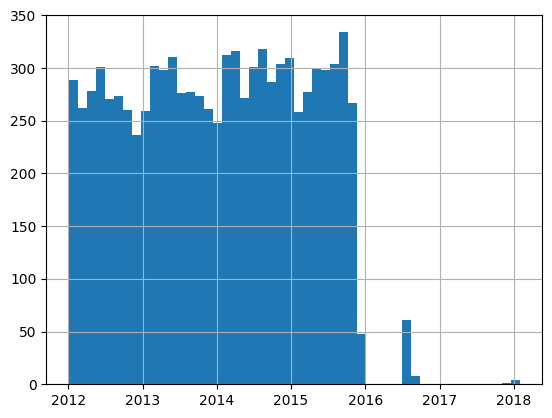

In [65]:
hy_vee_des_moines['Date'].hist(bins=50);

Ah, there are a few random sales in here from 2016-2018, but we'd really only use the sales from Janurary 2012 - November 2015.

In [ ]:
hy_vee_des_moines = hy_vee_des_moines[hy_vee_des_moines['Date'] < '2015-12-31']
hy_vee_des_moines['Date'].max()

Timestamp('2015-11-30 00:00:00')

It's too bad it doesn't contain sales from December 2015 to help round out that year. That means we only have three *complete* years of data (2012, 2013, and 2014).

In [66]:
hy_vee_des_moines = hy_vee_des_moines[hy_vee_des_moines['Date'] < '2014-12-31']
hy_vee_des_moines.shape

(6994, 7)

In [67]:
hy_vee_des_moines.head(3)

,Date,Store Number,Category Name,Vendor Name,Pack,Bottles Sold,Sale (Dollars)
1,2013-10-10,2633,LIQUEUR,MHW Ltd,6,6,134.94
20,2012-04-19,2633,VODKA,Phillips Beverage Company,12,12,135.00
95,2014-11-13,2633,VODKA,Phillips Beverage Company,6,1,15.99


Let's carefully consolidate these into more generalized categories. On one hand, we need to narrow these down for clarity and modeling purposes. On the other hand, we don't want to eliminate too many categories, especially those with a larger value count.

For example, instead of just consolidating everything containing the string 'VODKA' to a general 'VODKA' category, we can at least distinguish between 'VODKA' and a new category called 'FLAVORED VODKA'. We can also do something like divide the whiskey categories into three new ones: 'BOURBON', 'SCOTCH', and 'OTHER WHISKEY'.



In [ ]:
#Let's go back to the main DataFrame to refrence these categories
# and drop from there.
print(df['Category Name'].value_counts().to_string())

Category Name
VODKA 80 PROOF                          130687
CANADIAN WHISKIES                        97766
STRAIGHT BOURBON WHISKIES                57021
SPICED RUM                               55598
VODKA FLAVORED                           52326
BLENDED WHISKIES                         47028
TEQUILA                                  45050
IMPORTED VODKA                           43040
PUERTO RICO & VIRGIN ISLANDS RUM         42680
WHISKEY LIQUEUR                          33616
AMERICAN COCKTAILS                       30734
FLAVORED RUM                             29375
AMERICAN DRY GINS                        27623
IMPORTED VODKA - MISC                    27399
MISC. IMPORTED CORDIALS & LIQUEURS       26579
AMERICAN GRAPE BRANDIES                  26035
TENNESSEE WHISKIES                       25727
CREAM LIQUEURS                           24791
SCOTCH WHISKIES                          21475
IMPORTED SCHNAPPS                        18274
IMPORTED GRAPE BRANDIES                  15988

ValueError: Cannot mask with non-boolean array containing NA / NaN values

In [ ]:
hy_vee_des_moines.info()

In [ ]:
hy_vee_des_moines['Pack'].value_counts()

In [ ]:
len(hy_vee_des_moines['Vendor Name'].unique())

In [ ]:
hy_vee_des_moines['Vendor Name'].value_counts()

In [ ]:
hvdm_vendor_counts = hy_vee_des_moines['Vendor Name'].value_counts()
hvdm__100_order_vendors = pd.DataFrame(hvdm_vendor_counts)
hvdm__100_order_vendors = hvdm__100_order_vendors[hvdm__100_order_vendors['count']>= 100]
hvdm__100_order_vendors

In [ ]:
sum(hvdm__100_order_vendors['count'])

In [ ]:
hy_vee_des_moines['State Bottle Retail'].hist(bins=30);

In [ ]:
hy_vee_des_moines['Bottles Sold'].hist(bins=10);

In [ ]:
hy_vee_des_moines['Date'].hist(bins=36);

In [ ]:
rolling_hy_vee = hy_vee_des_moines['Bottles Sold'].rolling(window=6, center=False).mean()
rolling_hy_vee.hist();

In [ ]:
hy_vee_des_moines.sample(50)